In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [2]:
def moving_avrg(curve, weight):
    curve = curve[0]
    stdCurve = curve[1]
    avrg_mean = []
    avrg_std = []
    moving_mean = curve[0]
    moving_std = stdCurve[0]
    for i in range(1, len(curve)):
        moving_mean = weight * moving_mean + (1 - weight) * curve[i]
        moving_std = weight * moving_std + (1 - weight) * stdCurve[i]
        avrg_mean.append(moving_mean)
        avrg_std.append(moving_std)
    return np.array(avrg_mean), np.array(avrg_std)

In [3]:
def plot_upper_bound(dataset, budget, color, alpha=0.8, percentile=0.98, linewidth=2, run_name="UpperBound"):
    file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", dataset, f"{run_name}/accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    # mean = np.mean(all_runs.values, axis=1)
    mean = np.median(all_runs.values, axis=1)
    mean_percentile = percentile * mean
    mean = [float(mean)]*budget
    mean_percentile = [float(mean_percentile)]*budget
    plt.plot(range(budget), mean, label="upper bound", linewidth=linewidth, c=color, alpha=alpha)
    plt.plot(range(budget), mean_percentile, label="98% Percentile", linewidth=1, linestyle='--', c=color, alpha=0.6)

In [4]:
def plot_benchmark(path, color, display_name, smoothing_weight=0.0, alpha=0.8, linewidth=1.5, plot_std=True):
    file = os.path.join("/home/thorben/phd/projects/al-benchmark/runs", path, "accuracies.csv")
    all_runs = pd.read_csv(file, header=0, index_col=0)
    mean = np.median(all_runs.values, axis=1)
    # mean = np.mean(all_runs.values, axis=1)
    std = np.std(all_runs.values, axis=1)
    curve = np.stack([mean, std])
    auc = round(sum(mean) / len(mean), 3)
    if smoothing_weight > 0.0:
        avrg_curve, std_curve = moving_avrg(curve, smoothing_weight)
    else:
        avrg_curve, std_curve = mean, std
    full_name = f"{display_name} - AUC: {auc}"
    x = np.arange(len(avrg_curve))
    if plot_std:
        avrg_std = round(sum(std) / len(std), 3)
        full_name += f"+-{avrg_std}"
        plt.fill_between(x, avrg_curve-std_curve, avrg_curve+std_curve, alpha=0.5, facecolor=color)
    plt.plot(x, avrg_curve, label=full_name, linewidth=linewidth, c=color, alpha=alpha)
    return len(x)

# Scissor

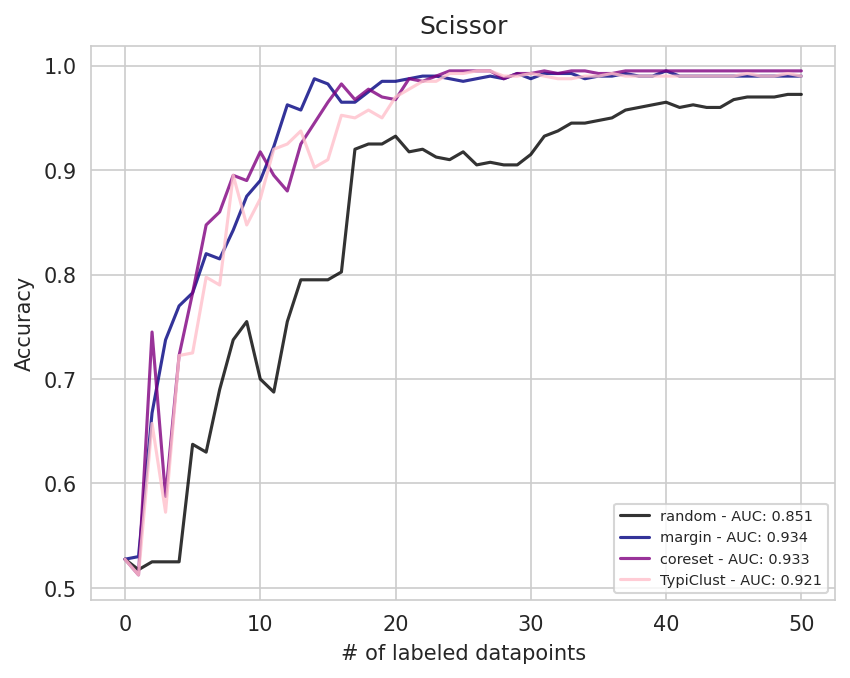

In [5]:
plt.figure(dpi=150)
plot_std = False

# plot_benchmark("Scissor/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("Scissor/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("Scissor/MarginScore", "navy", display_name="margin", plot_std=plot_std)
# plot_benchmark("Scissor/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("Scissor/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
# plot_benchmark("Scissor/Badge", "orange", display_name="badge", plot_std=plot_std)
# plot_benchmark('Scissor/SAL_23_01_16', 'orange', display_name='SAL', plot_std=plot_std)
plot_benchmark("Scissor/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
# plot_upper_bound('Scissor', 600, "black", percentile=0.99)

plt.title('Scissor')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# ThreeClust

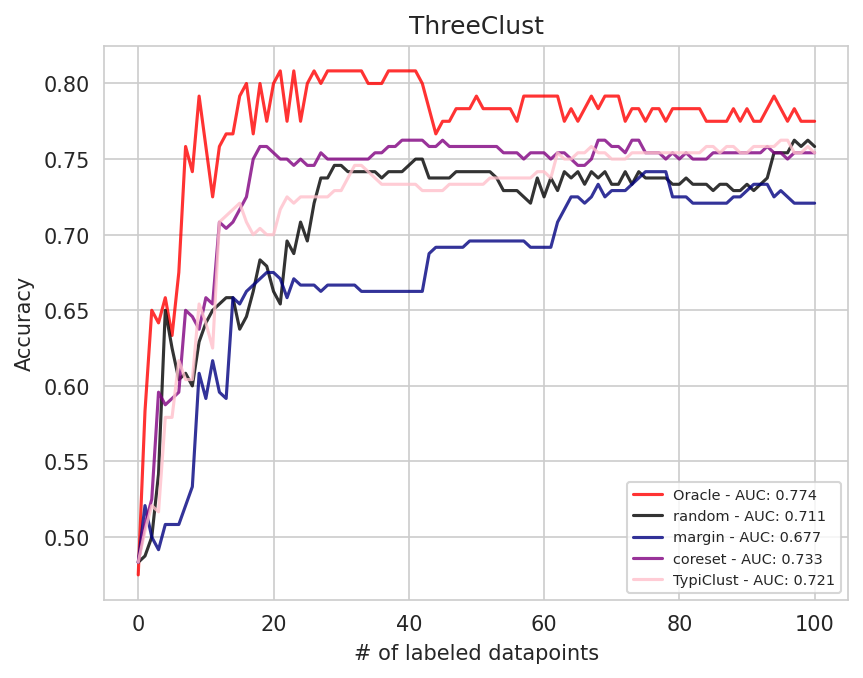

In [6]:
plt.figure(dpi=150)
plot_std = False

plot_benchmark("ThreeClust/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("ThreeClust/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("ThreeClust/MarginScore", "navy", display_name="margin", plot_std=plot_std)
# plot_benchmark("ThreeClust/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("ThreeClust/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
# plot_benchmark("ThreeClust/Badge", "orange", display_name="badge", plot_std=plot_std)
# plot_benchmark('ThreeClust/SAL_23_01_16', 'orange', display_name='SAL', plot_std=plot_std)
plot_benchmark("ThreeClust/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
# plot_upper_bound('Splice', 600, "black", percentile=0.99)

plt.title('ThreeClust')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# Splice

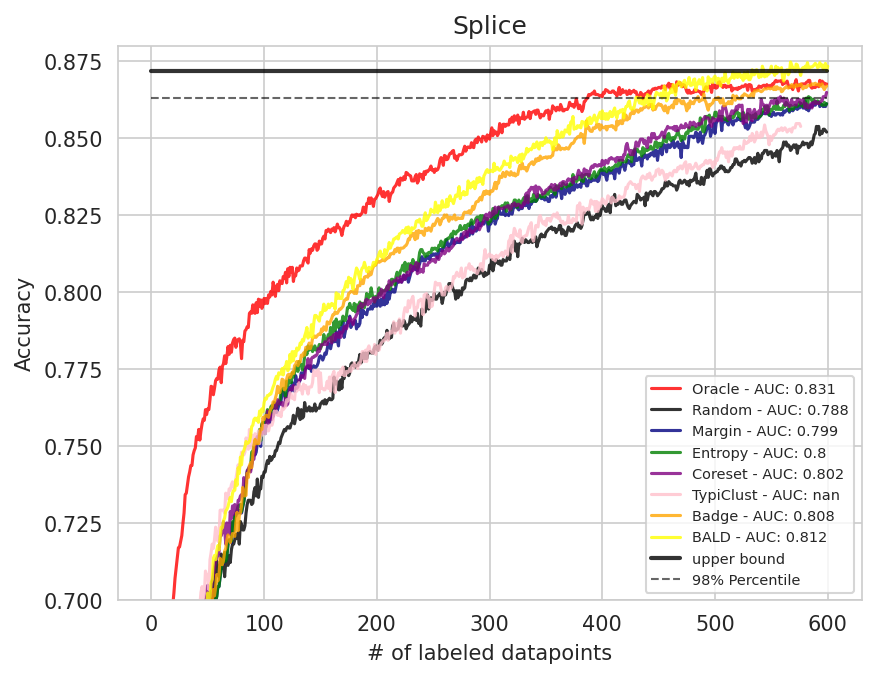

In [7]:
plt.figure(dpi=150)
plot_std = False

plot_benchmark("Splice/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("Splice/RandomAgent", "black", display_name="Random", plot_std=plot_std)
plot_benchmark("Splice/MarginScore", "navy", display_name="Margin", plot_std=plot_std)
plot_benchmark("Splice/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("Splice/Coreset_Greedy", "purple", display_name="Coreset", plot_std=plot_std)
plot_benchmark("Splice/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("Splice/Badge", "orange", display_name="Badge", plot_std=plot_std)
plot_benchmark("Splice/BALD", "yellow", display_name="BALD", plot_std=plot_std)
# plot_benchmark('Splice/SAL_23_01_16', 'orange', display_name='SAL', plot_std=plot_std)
plot_upper_bound('Splice', 600, "black", percentile=0.99)

plt.title('Splice')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.7, 0.88)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# DNA

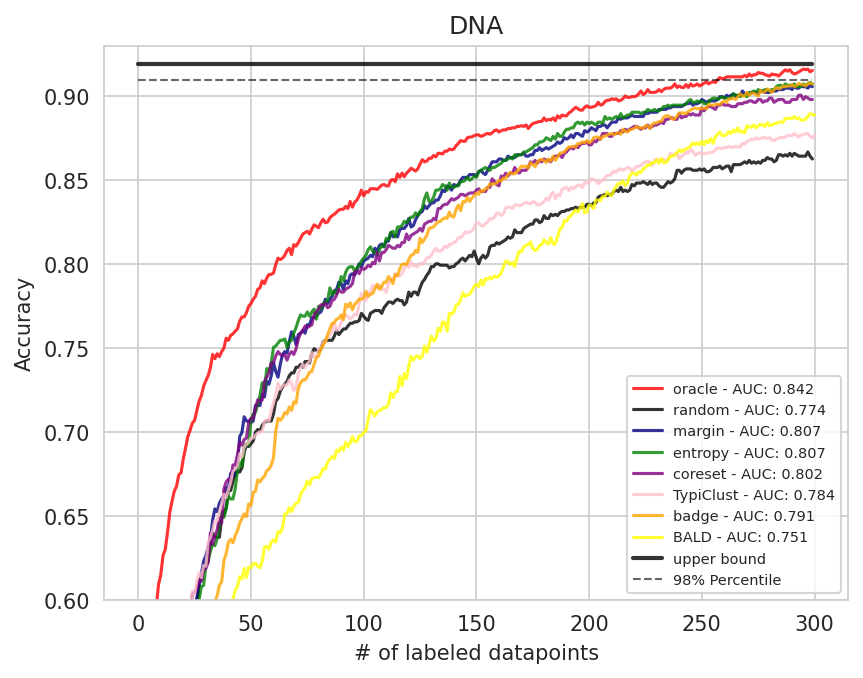

In [8]:
plot_std = False
plt.figure(dpi=150)
# plot('../baselines/dna/oracle_finetuning.npy', 'orange', display_name='oracle_finetuning', weight=0.6)

plot_benchmark('DNA/Oracle', 'red', display_name='oracle', plot_std=plot_std)
plot_benchmark("DNA/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("DNA/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("DNA/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("DNA/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("DNA/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("DNA/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("DNA/BALD", "yellow", display_name="BALD", plot_std=plot_std)
plot_upper_bound("DNA", 300, "black", percentile=0.99)

plt.title('DNA')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.6, 0.93)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# USPS

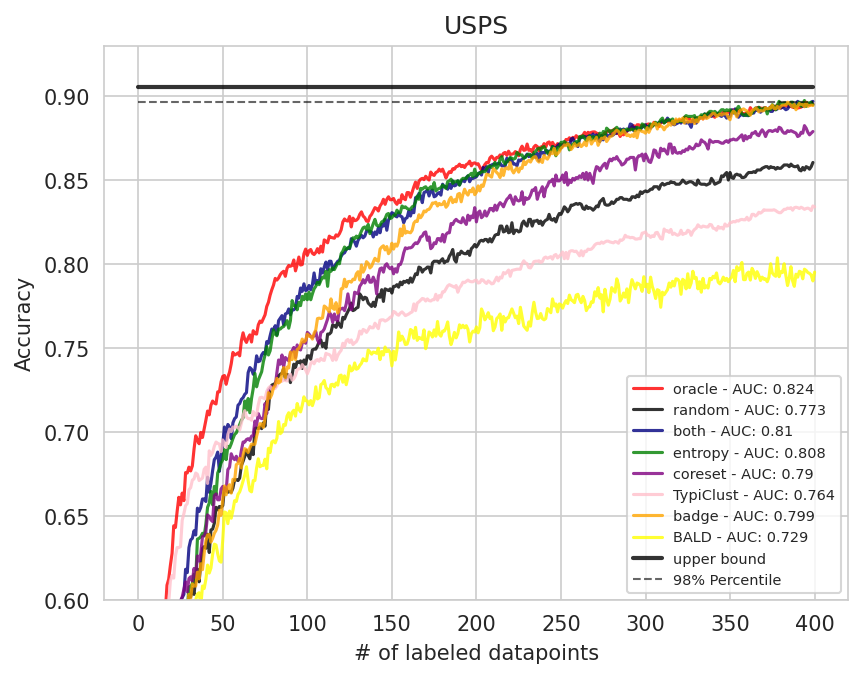

In [9]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark('USPS/Oracle', 'red', display_name='oracle', plot_std=plot_std)
plot_benchmark("USPS/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("USPS/MarginScore", "navy", display_name="both", plot_std=plot_std)
plot_benchmark("USPS/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("USPS/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("USPS/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("USPS/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("USPS/BALD", "yellow", display_name="BALD", plot_std=plot_std)
plot_upper_bound("USPS", 400, "black", percentile=0.99)

plt.title('USPS')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.6, 0.93)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# Cifar10 Encoded

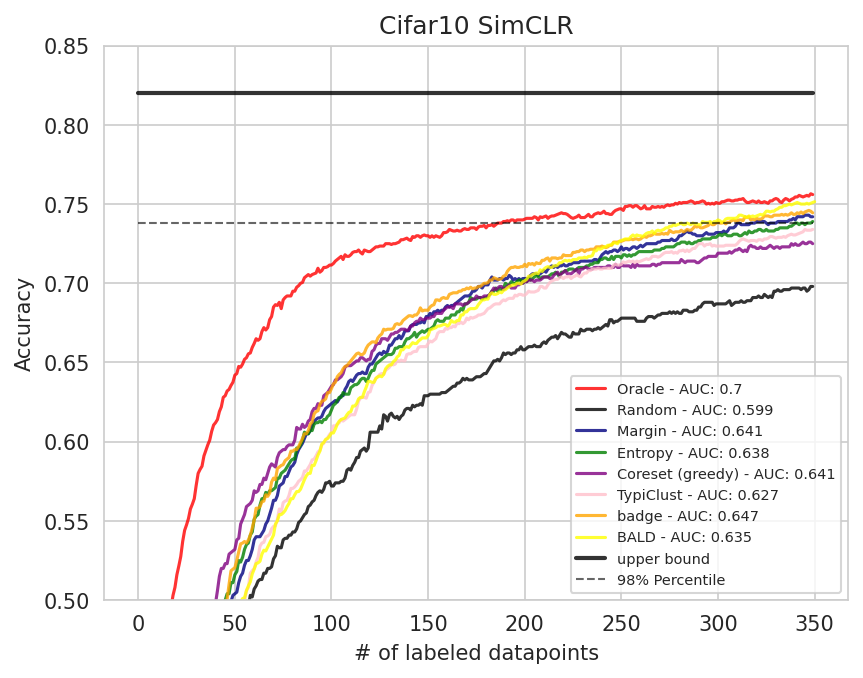

In [10]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("Cifar10Encoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/RandomAgent", "black", display_name="Random", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/MarginScore", "navy", display_name="Margin", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/ShannonEntropy", "green", display_name="Entropy", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/Coreset_Greedy", "purple", display_name="Coreset (greedy)", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("Cifar10Encoded/BALD", "yellow", display_name="BALD", plot_std=plot_std)
# plot_benchmark("Cifar10Encoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("Cifar10Encoded", 350, "black", percentile=0.9)

plt.title('Cifar10 SimCLR')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.5, 0.85)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# FashionMnist Encoded

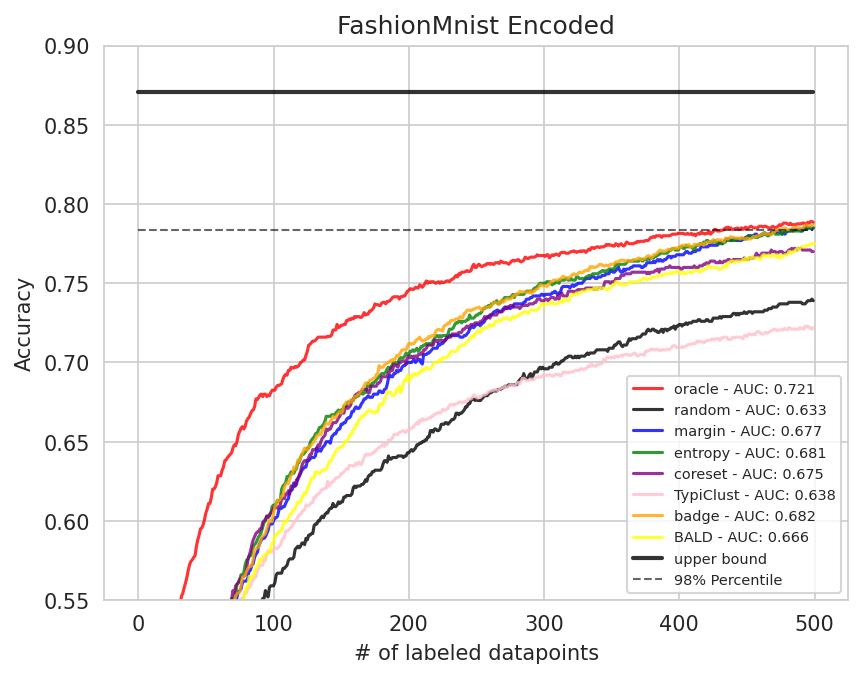

In [11]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("FashionMnistEncoded/Oracle", "red", display_name="oracle", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/MarginScore", "blue", display_name="margin", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("FashionMnistEncoded/BALD", "yellow", display_name="BALD", plot_std=plot_std)
# plot_benchmark("FashionMnistEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("FashionMnistEncoded", 500, "black", percentile=0.9)

plt.title('FashionMnist Encoded')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.55, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# TopV2

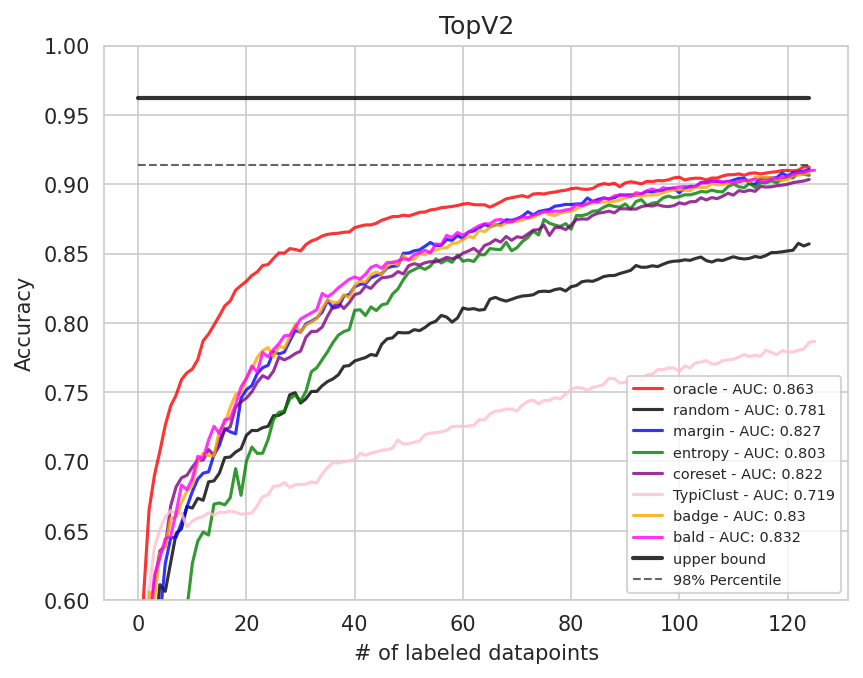

In [12]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("TopV2/Oracle", "red", display_name="oracle", plot_std=plot_std)
plot_benchmark("TopV2/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("TopV2/MarginScore", "blue", display_name="margin", plot_std=plot_std)
plot_benchmark("TopV2/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("TopV2/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("TopV2/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("TopV2/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("TopV2/BALD", "magenta", display_name="bald", plot_std=plot_std)
# plot_benchmark("TopV2/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("TopV2", 125, "black", percentile=0.95)

plt.title('TopV2')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.6, 1.0)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# News

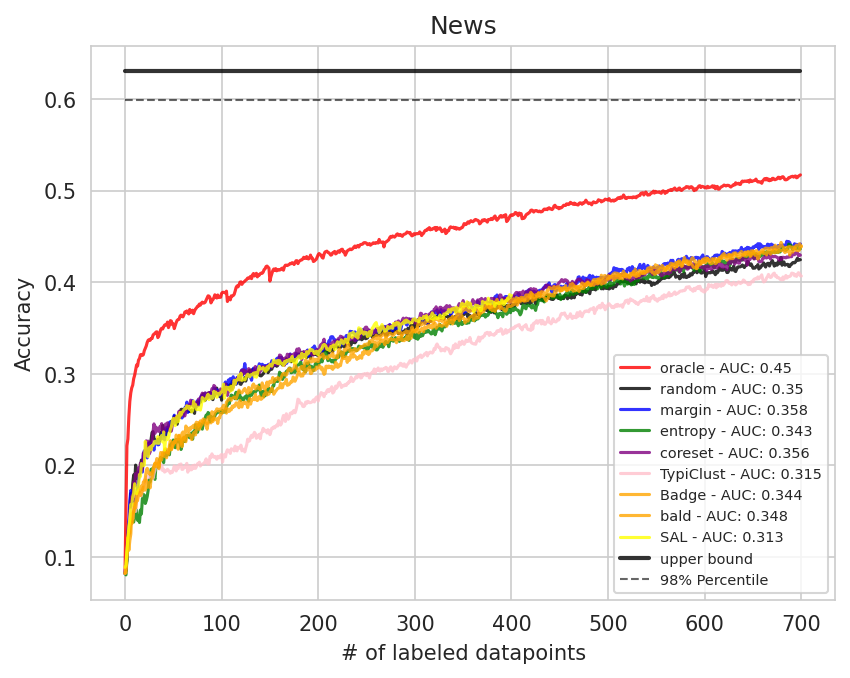

In [13]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("News/Oracle", "red", display_name="oracle", plot_std=plot_std)
plot_benchmark("News/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("News/MarginScore", "blue", display_name="margin", plot_std=plot_std)
plot_benchmark("News/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("News/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("News/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("News/Badge", "orange", display_name="Badge", plot_std=plot_std)
plot_benchmark("News/BALD", "orange", display_name="bald", plot_std=plot_std)
plot_benchmark("News/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound("News", 700, "black", percentile=0.95)

plt.title('News')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.55, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# Splice Embedded

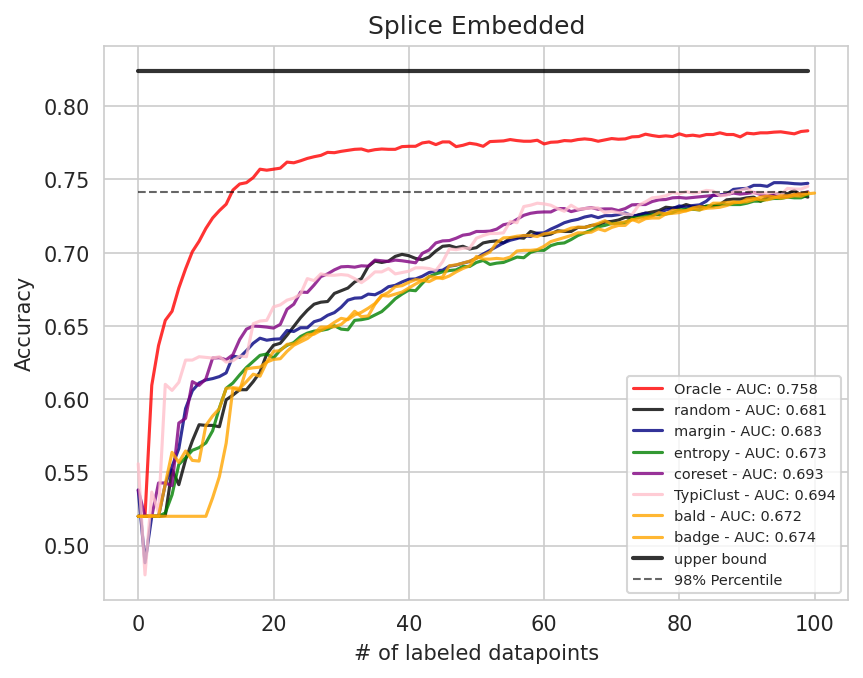

In [14]:
plt.figure(dpi=150)
plot_std = False

plot_benchmark("SpliceEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("SpliceEncoded/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("SpliceEncoded/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("SpliceEncoded/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("SpliceEncoded/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("SpliceEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("SpliceEncoded/BALD", "orange", display_name="bald", plot_std=plot_std)
plot_benchmark("SpliceEncoded/Badge", "orange", display_name="badge", plot_std=plot_std)
# plot_benchmark("SpliceEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound('SpliceEncoded', 100, "black", percentile=0.9)

plt.title('Splice Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# DNA Embedded

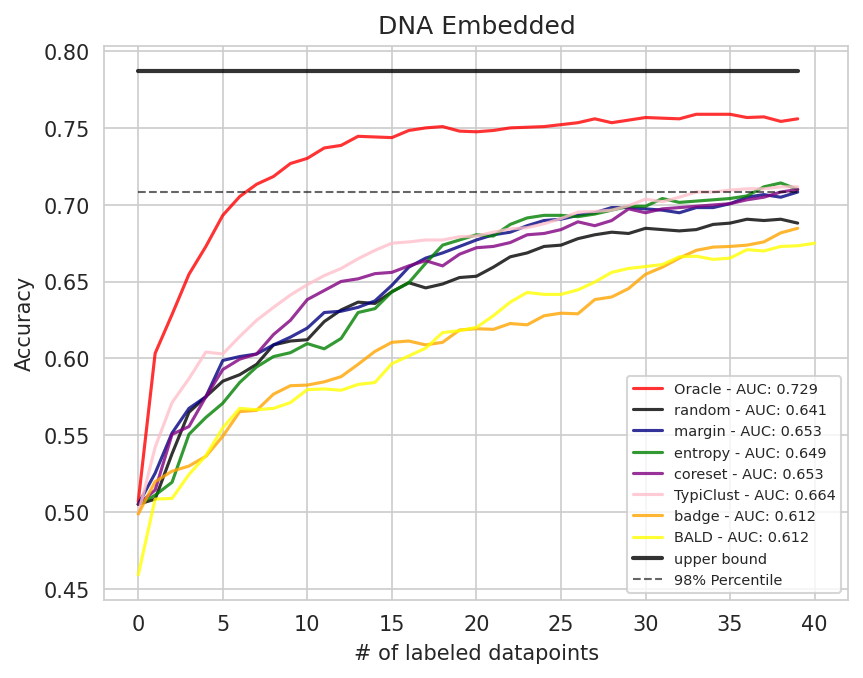

In [15]:
plt.figure(dpi=150)
plot_std = False

plot_benchmark("DNAEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("DNAEncoded/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("DNAEncoded/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("DNAEncoded/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("DNAEncoded/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("DNAEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("DNAEncoded/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("DNAEncoded/BALD", "yellow", display_name="BALD", plot_std=plot_std)
# plot_benchmark("DNAEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound('DNAEncoded', 40, "black", percentile=0.9)

plt.title('DNA Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# USPS Embedded

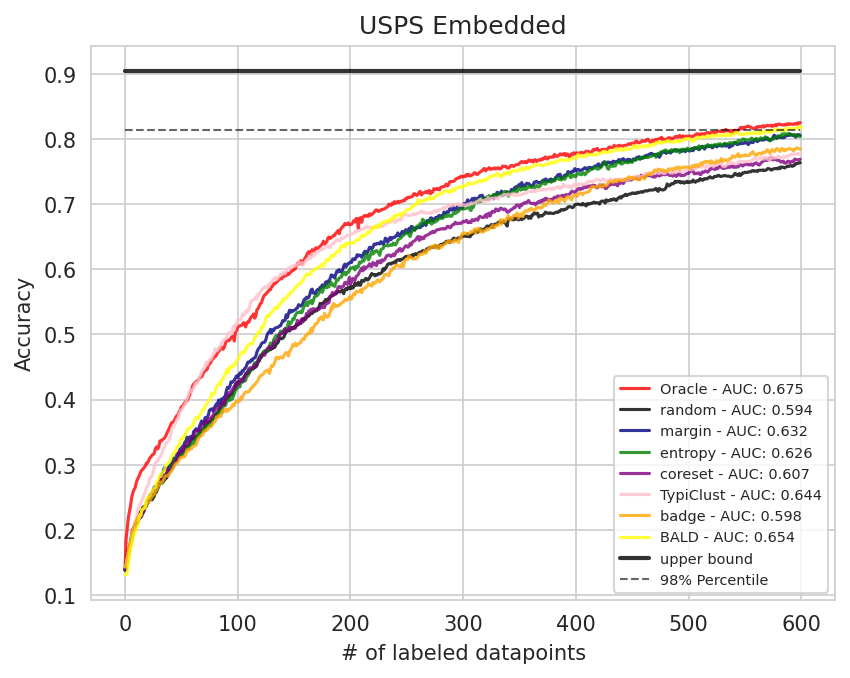

In [16]:
plt.figure(dpi=150)
plot_std = False

plot_benchmark("USPSEncoded/Oracle", "red", display_name="Oracle", plot_std=plot_std)
plot_benchmark("USPSEncoded/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("USPSEncoded/MarginScore", "navy", display_name="margin", plot_std=plot_std)
plot_benchmark("USPSEncoded/ShannonEntropy", "green", display_name="entropy", plot_std=plot_std)
plot_benchmark("USPSEncoded/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_benchmark("USPSEncoded/TypiClust", "pink", display_name="TypiClust", plot_std=plot_std)
plot_benchmark("USPSEncoded/Badge", "orange", display_name="badge", plot_std=plot_std)
plot_benchmark("USPSEncoded/BALD", "yellow", display_name="BALD", plot_std=plot_std)
# plot_benchmark("USPSEncoded/SAL_23_01_16", "yellow", display_name="SAL", plot_std=plot_std)
plot_upper_bound('USPSEncoded', 600, "black", percentile=0.9)

plt.title('USPS Embedded')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.7, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# Cifar10

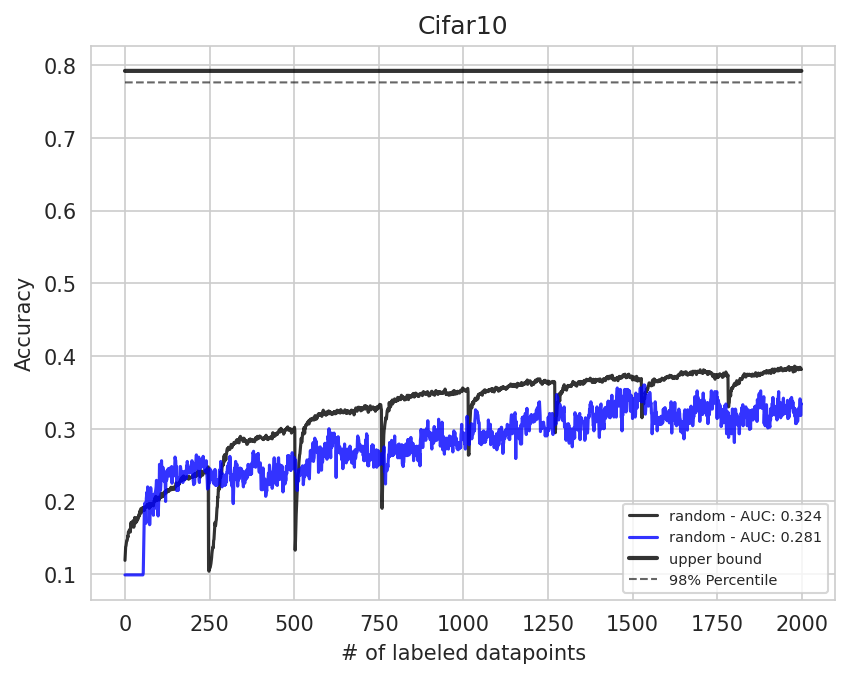

In [17]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("Cifar10/RandomAgentDrops", "black", display_name="random", plot_std=plot_std)
plot_benchmark("Cifar10/RandomAgent", "blue", display_name="random", plot_std=plot_std)
plot_upper_bound("Cifar10", 2000, "black")

plt.title('Cifar10')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
# plt.ylim(0.8, 0.95)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()

# FashionMnist

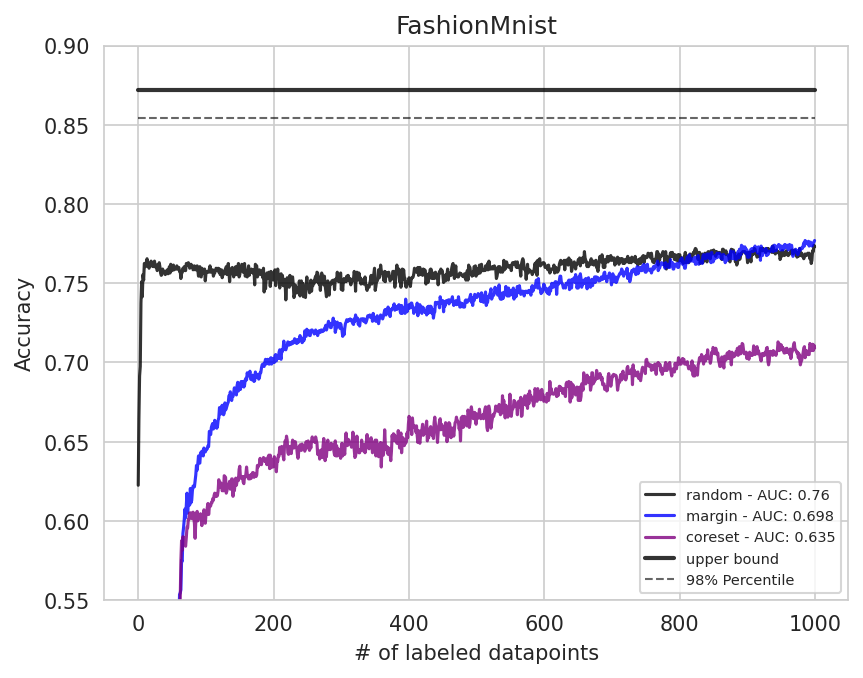

In [18]:
plot_std = False
plt.figure(dpi=150)

plot_benchmark("FashionMnist/RandomAgent", "black", display_name="random", plot_std=plot_std)
plot_benchmark("FashionMnist/MarginScore", "blue", display_name="margin", plot_std=plot_std)
plot_benchmark("FashionMnist/Coreset_Greedy", "purple", display_name="coreset", plot_std=plot_std)
plot_upper_bound("FashionMnist", 1000, "black")

plt.title('FashionMnist')
plt.ylabel('Accuracy')
plt.xlabel('# of labeled datapoints')
plt.ylim(0.55, 0.9)
plt.grid(visible=True)
plt.legend(fontsize='x-small')
plt.show()